Import required Libraries

In [56]:
import os
import sys
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0,rpath)
from src import utils
from src.plots import Plot
from src.preprocessing import PreProcess
from src.overview import Overview

In [6]:
df = pd.read_csv('../data/cleaned_data_outliers.csv')

In [7]:
plots = Plot()
preprocess = PreProcess(df)
overview = Overview(df)

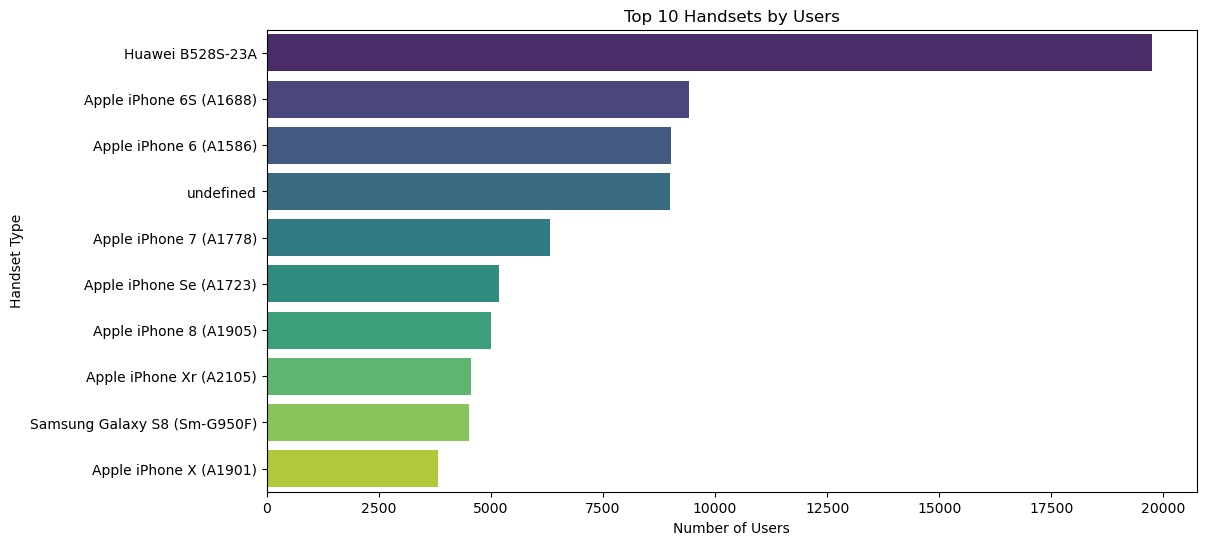

In [8]:
#Identify top 10 handsets used by the customers
handset_counts = df['Handset Type'].value_counts().head(10)
plots.plot_bar(x=handset_counts.values, y=handset_counts.index, xlabel='Number of Users', title='Top 10 Handsets by Users',ylabel='Handset Type')

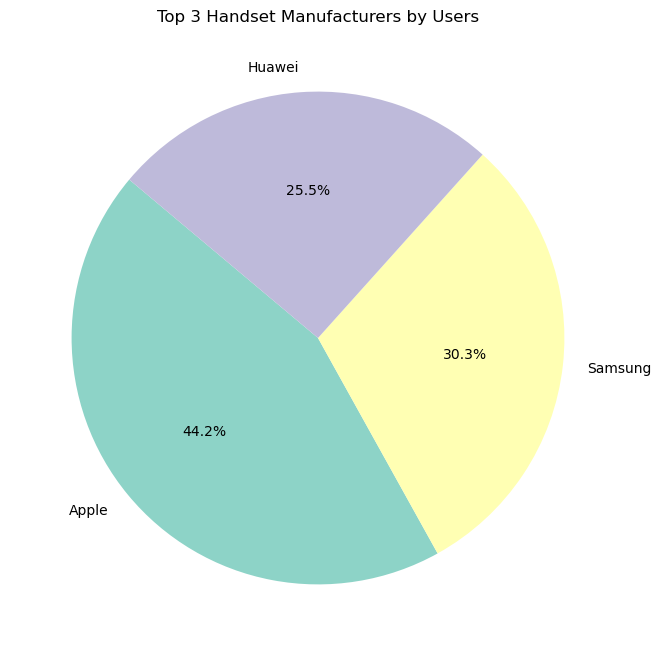

In [9]:
manufacturer_counts = df['Handset Manufacturer'].value_counts().head(3)
plots.plot_pie(manufacturer_counts, title='Top 3 Handset Manufacturers by Users')

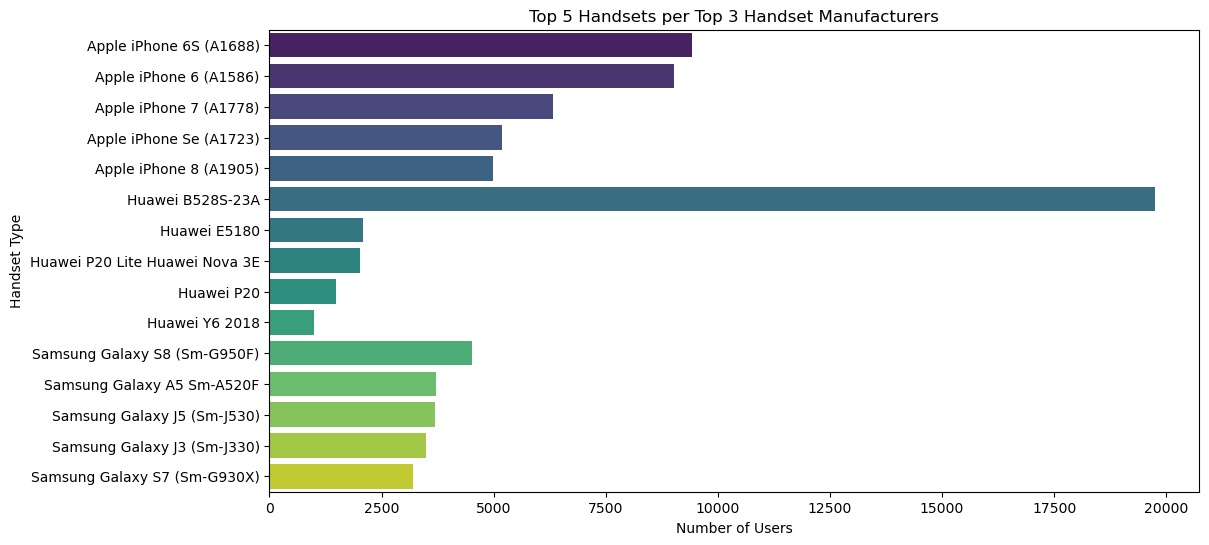

In [10]:
top_manufacturers = df['Handset Manufacturer'].value_counts().head(3).index

# Filter the DataFrame to include only the top 3 manufacturers
df_top_manufacturers = df[df['Handset Manufacturer'].isin(top_manufacturers)]

# Get the top 5 handsets for each manufacturer
top_handsets_per_manufacturer = (
    df_top_manufacturers
    .groupby('Handset Manufacturer')['Handset Type']
    .value_counts()
    .groupby(level=0, group_keys=False)
    .nlargest(5)
    .reset_index(name='Count')
)

plots.plot_bar(x=top_handsets_per_manufacturer['Count'], y=top_handsets_per_manufacturer['Handset Type'], xlabel='Number of Users', title='Top 5 Handsets per Top 3 Handset Manufacturers',ylabel='Handset Type',palette='viridis')


In [11]:
# Group by User and calculate the number of sessions
xDR_sess_agg = df['MSISDN/Number'].value_counts()
print(xDR_sess_agg.nlargest(10))

MSISDN/Number
3.362632e+10    18
3.361489e+10    17
3.362578e+10    17
3.365973e+10    16
3.376054e+10    15
3.367588e+10    15
3.366716e+10    13
3.360313e+10    12
3.378632e+10    12
3.376041e+10    12
Name: count, dtype: int64


In [12]:
df.groupby('MSISDN/Number')['Dur. (ms)'].sum().nlargest(10)

MSISDN/Number
3.362578e+10    233.413129
3.362632e+10    231.977427
3.361489e+10    222.446521
3.365973e+10    198.016024
3.376054e+10    195.767900
3.367588e+10    188.665113
3.366716e+10    172.629643
3.360313e+10    156.933829
3.360452e+10    154.378835
3.376041e+10    154.085482
Name: Dur. (ms), dtype: float64

In [13]:
#  total download (DL) 
df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum().nlargest(10, 'Total DL (Bytes)')

,Total DL (Bytes),Total UL (Bytes)
MSISDN/Number,,
3.362632e+10,354.469774,313.238174
3.361489e+10,336.610039,296.955644
3.362578e+10,336.420166,298.278567
3.365973e+10,313.799886,279.152641
3.367588e+10,297.810275,261.389693
3.376054e+10,297.518869,264.702722
3.366716e+10,254.286268,228.070512
3.376041e+10,239.418673,210.802513
3.362708e+10,236.605837,208.397906


In [14]:
df["social_media"] = df["Social Media DL (Bytes)"] + df['Social Media UL (Bytes)']
df["google"] = df["Google DL (Bytes)"] + df["Google UL (Bytes)"]
df['email'] = df["Email DL (Bytes)"] + df["Email UL (Bytes)"]
df['youtube'] = df["Youtube DL (Bytes)"] + df["Youtube UL (Bytes)"]
df['netflix'] = df["Netflix DL (Bytes)"] + df["Netflix UL (Bytes)"]
df["gaming"] = df["Gaming DL (Bytes)"] + df["Gaming UL (Bytes)"]
df['other'] = df["Other DL (Bytes)"]+df["Other UL (Bytes)"]
df['total_data'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

#### Interpretation and recommendation to marketing teams

Based on the above analysis, The following is recommended:
As most of the users are using devices from Manufacturers of Apple, Samsung, and Huawei, the sales team should focus on these product owners.
Customers' best-performing devices might be promoted by the marketing team. Huawei may be considered for a cross promotion due to their products holding the most slots in the top ten handsets. Samsung and Apple are also considered for cross promotion.

In [15]:
quantitative_vars = df.select_dtypes(include=['float64', 'int64'])

# Calculate dispersion parameters
dispersion_parameters = pd.DataFrame({
    'Mean': quantitative_vars.mean(),
    'Std Deviation': quantitative_vars.std(),
    'Min': quantitative_vars.min(),
    '25th Percentile (Q1)': quantitative_vars.quantile(0.25),
    'Median (Q2)': quantitative_vars.median(),
    '75th Percentile (Q3)': quantitative_vars.quantile(0.75),
    'Max': quantitative_vars.max(),
    'IQR': quantitative_vars.quantile(0.75) - quantitative_vars.quantile(0.25)
})

# Display the results
print(dispersion_parameters)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


                                                  Mean  Std Deviation  \
Bearer Id                                 1.013887e+19   2.893173e+18   
Start ms                                  4.991882e+02   2.886118e+02   
End ms                                    4.988009e+02   2.880977e+02   
Dur. (ms)                                 1.131559e+01   7.289601e-01   
IMSI                                      3.296953e+01   1.030171e-04   
MSISDN/Number                             4.188282e+10   2.447443e+12   
IMEI                                      4.847455e+13   2.241637e+13   
Avg RTT DL (ms)                                   -inf            NaN   
Avg RTT UL (ms)                                   -inf            NaN   
Avg Bearer TP DL (kbps)                           -inf            NaN   
Avg Bearer TP UL (kbps)                           -inf            NaN   
TCP DL Retrans. Vol (Bytes)               1.274566e+01   3.326952e+00   
TCP UL Retrans. Vol (Bytes)               9.929537e

/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [16]:
# Calculate the correlation coefficients
correlation_coefficients = quantitative_vars.corr(method='pearson')
correlation_coefficients

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Total UL (Bytes),Total DL (Bytes),social_media,google,email,youtube,netflix,gaming,other,total_data
Bearer Id,1.000000,0.002961,-0.001219,0.012184,0.000204,-0.003307,0.164054,0.067067,0.263164,0.067973,...,-0.004271,0.000594,-0.003346,-0.000936,0.001905,-0.001119,-0.002798,-0.001663,-0.000518,-0.001037
Start ms,0.002961,1.000000,0.120945,0.001753,-0.000012,-0.001021,-0.001133,0.000574,0.001387,-0.002709,...,0.000467,-0.004354,-0.000605,0.001584,-0.001588,0.000777,-0.002695,-0.004806,-0.000233,-0.003873
End ms,-0.001219,0.120945,1.000000,-0.001697,0.000308,-0.001890,-0.000032,-0.002869,-0.005008,0.001014,...,-0.000777,-0.005516,-0.001007,0.000854,-0.002109,-0.004089,0.004999,-0.003019,0.002661,-0.005415
Dur. (ms),0.012184,0.001753,-0.001697,1.000000,-0.003886,0.009309,0.011620,-0.198275,-0.079459,-0.315075,...,-0.001449,0.001611,-0.003598,-0.002860,0.001707,0.002764,-0.006668,0.001941,0.002379,0.000958
IMSI,0.000204,-0.000012,0.000308,-0.003886,1.000000,-0.662640,-0.000624,0.000469,-0.004686,-0.000054,...,0.000519,0.005267,-0.001813,-0.004056,-0.001932,0.001694,-0.001963,0.003228,-0.000166,0.005088
MSISDN/Number,-0.003307,-0.001021,-0.001890,0.009309,-0.662640,1.000000,0.005703,0.019747,0.052152,-0.005371,...,0.004503,-0.004419,0.000699,0.002372,0.003081,0.004080,0.002122,-0.002010,0.000930,-0.002430
IMEI,0.164054,-0.001133,-0.000032,0.011620,-0.000624,0.005703,1.000000,0.140492,0.455955,0.368482,...,-0.000716,0.000477,-0.002804,0.000159,0.000284,-0.002187,-0.003642,0.001431,0.004296,0.000177
Avg RTT DL (ms),0.067067,0.000574,-0.002869,-0.198275,0.000469,0.019747,0.140492,1.000000,0.286702,0.302337,...,-0.000193,0.002143,-0.000135,0.003177,-0.001860,0.003688,-0.002462,-0.000261,-0.000048,0.001920
Avg RTT UL (ms),0.263164,0.001387,-0.005008,-0.079459,-0.004686,0.052152,0.455955,0.286702,1.000000,0.530241,...,0.004571,0.000511,-0.005901,-0.001944,-0.000165,-0.000278,0.002988,0.002063,0.003814,0.002177
Avg Bearer TP DL (kbps),0.067973,-0.002709,0.001014,-0.315075,-0.000054,-0.005371,0.368482,0.302337,0.530241,1.000000,...,0.002459,-0.003781,0.000130,-0.000478,-0.002126,0.000469,0.006291,-0.000568,0.003557,-0.002599


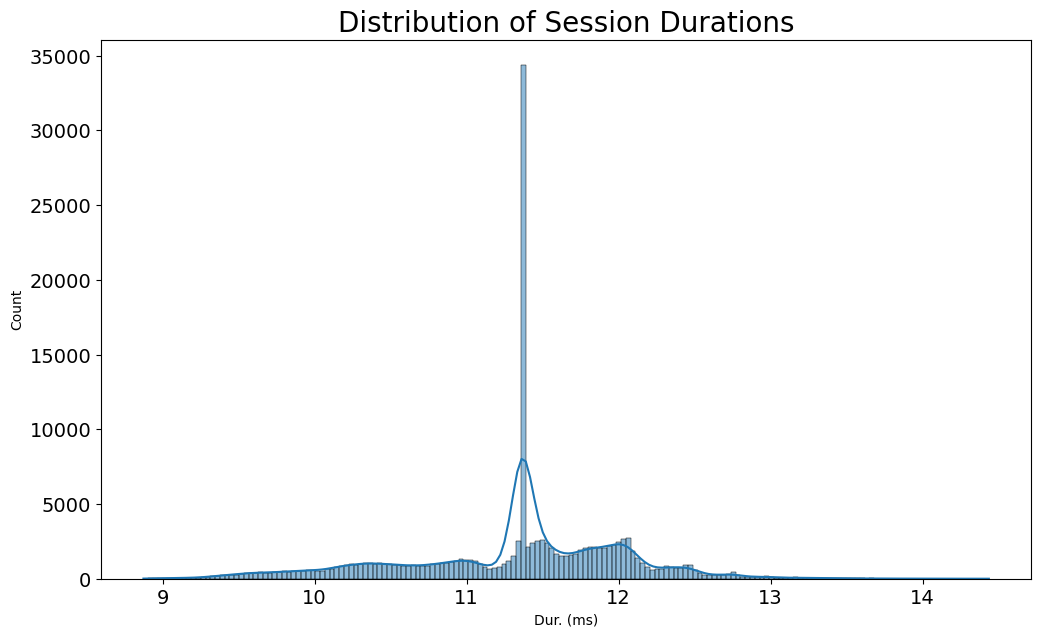

In [17]:
plots.plot_hist(df=df, column='Dur. (ms)', title='Distribution of Session Durations')

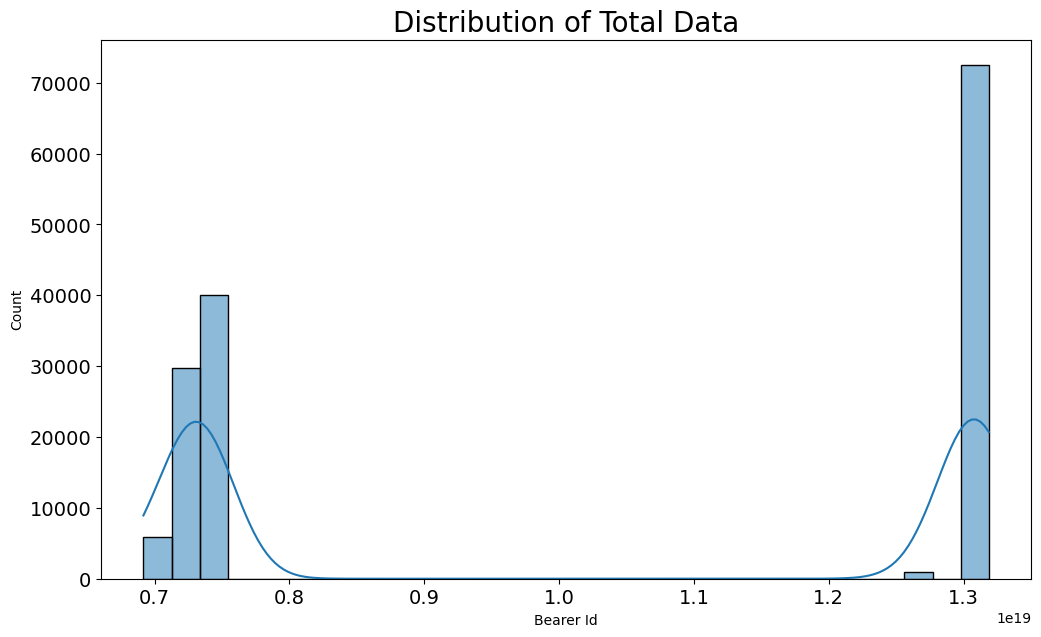

In [18]:
plots.plot_hist(df=df, column='Bearer Id', title='Distribution of Total Data')

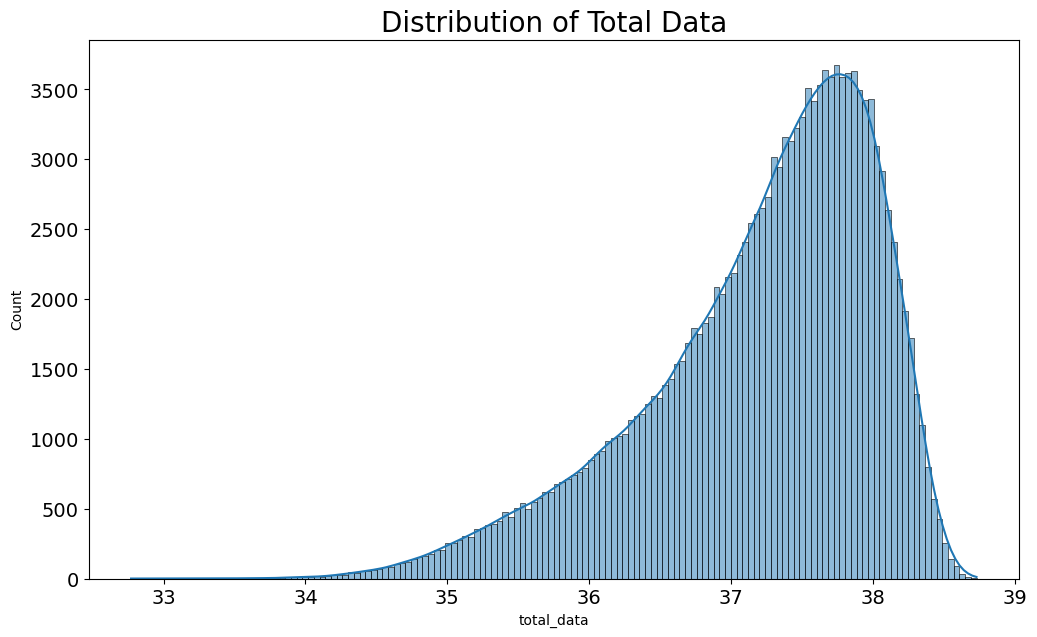

In [19]:
plots.plot_hist(df=df, column='total_data',title='Distribution of Total Data')

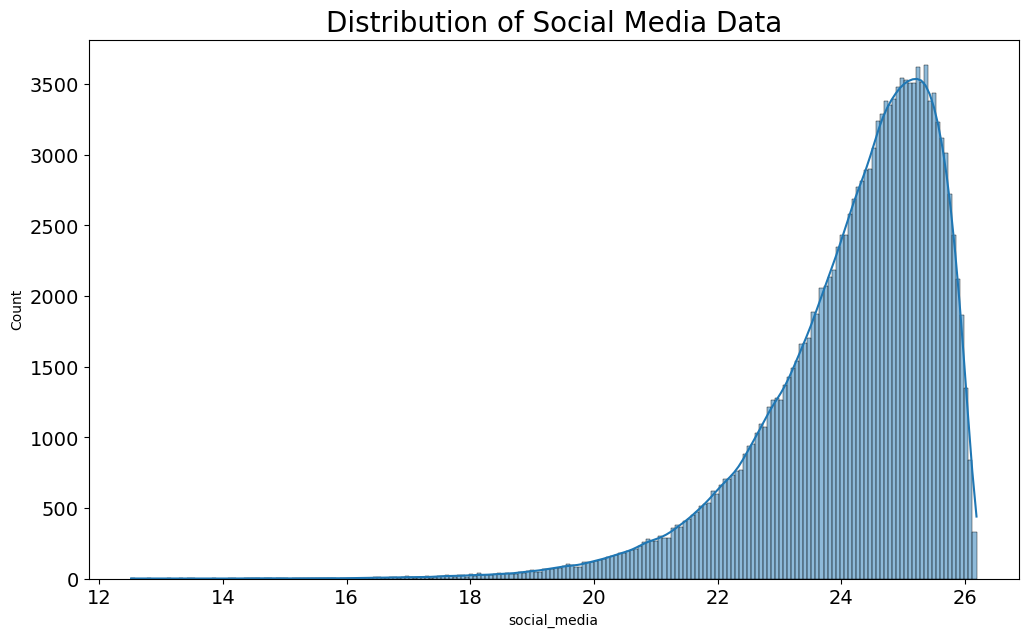

In [20]:
plots.plot_hist(df=df, column='social_media', title='Distribution of Social Media Data')

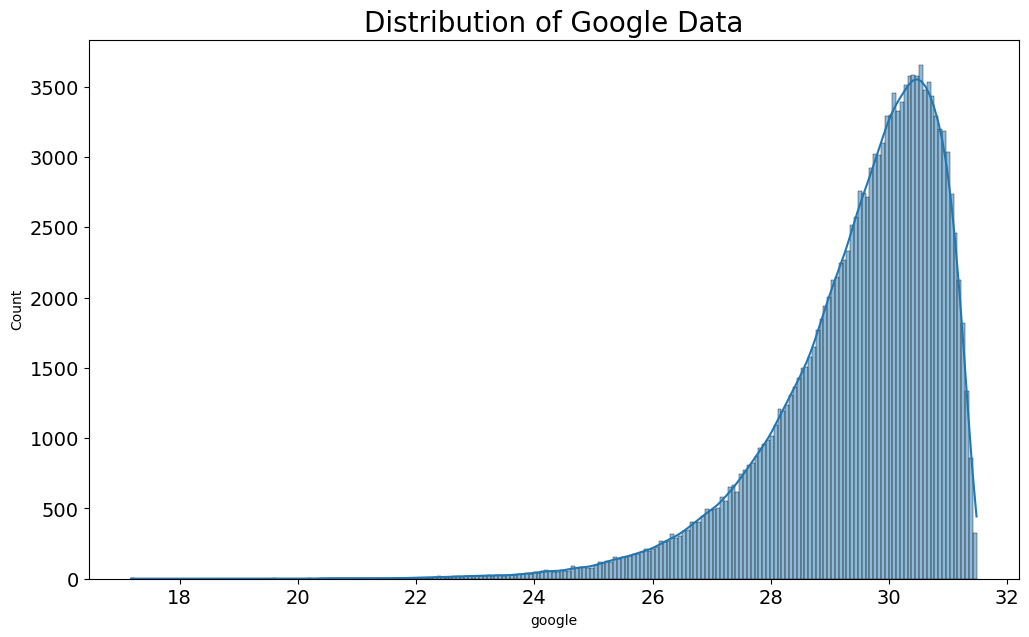

In [21]:
plots.plot_hist(df=df, column='google', title='Distribution of Google Data')

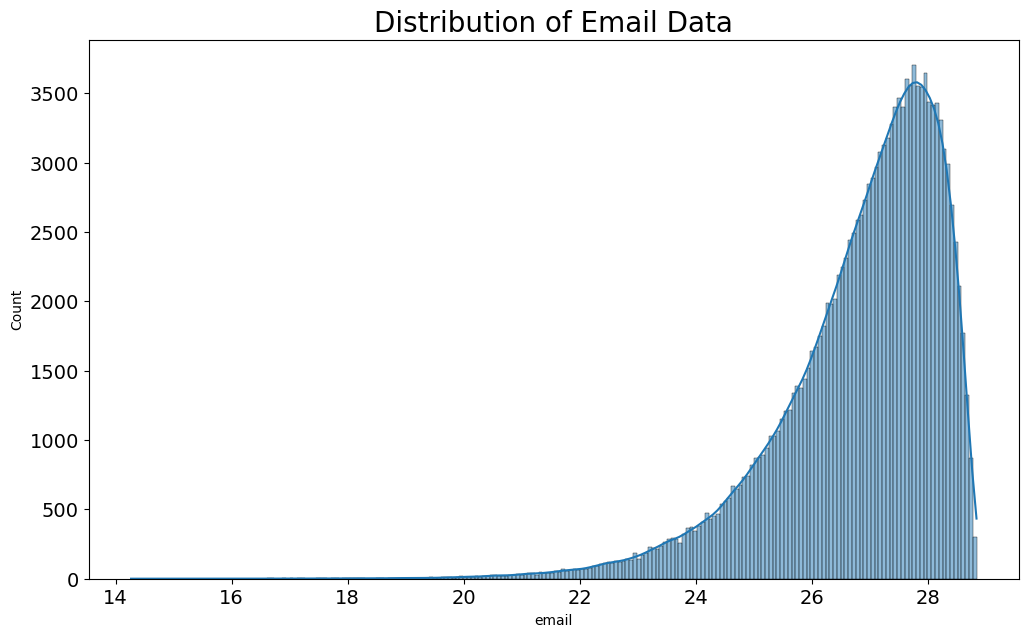

In [22]:
plots.plot_hist(df=df, column='email', title='Distribution of Email Data')

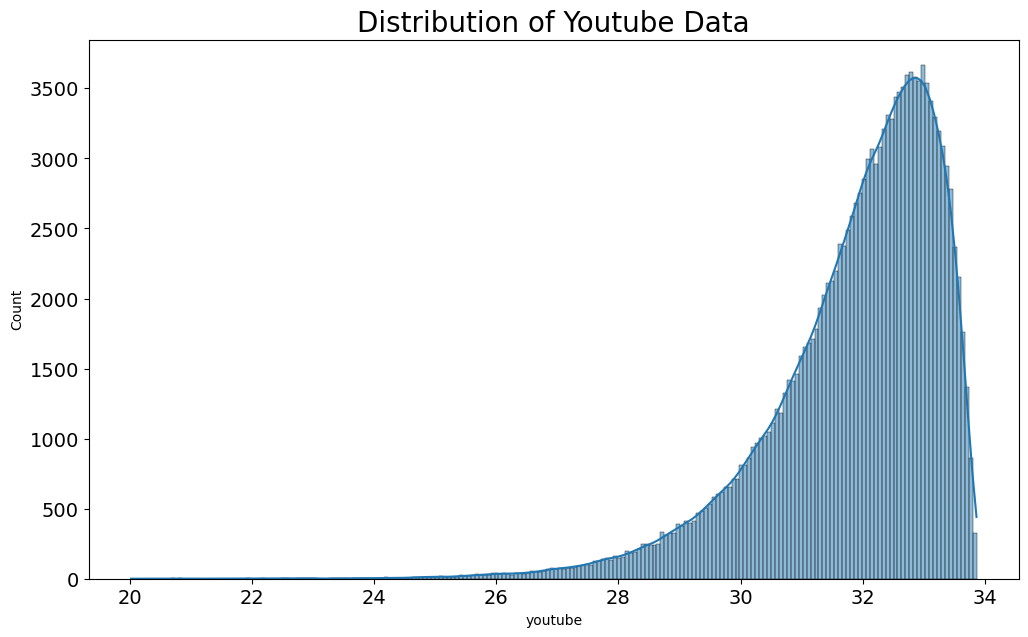

In [23]:
plots.plot_hist(df=df, column='youtube', title='Distribution of Youtube Data')

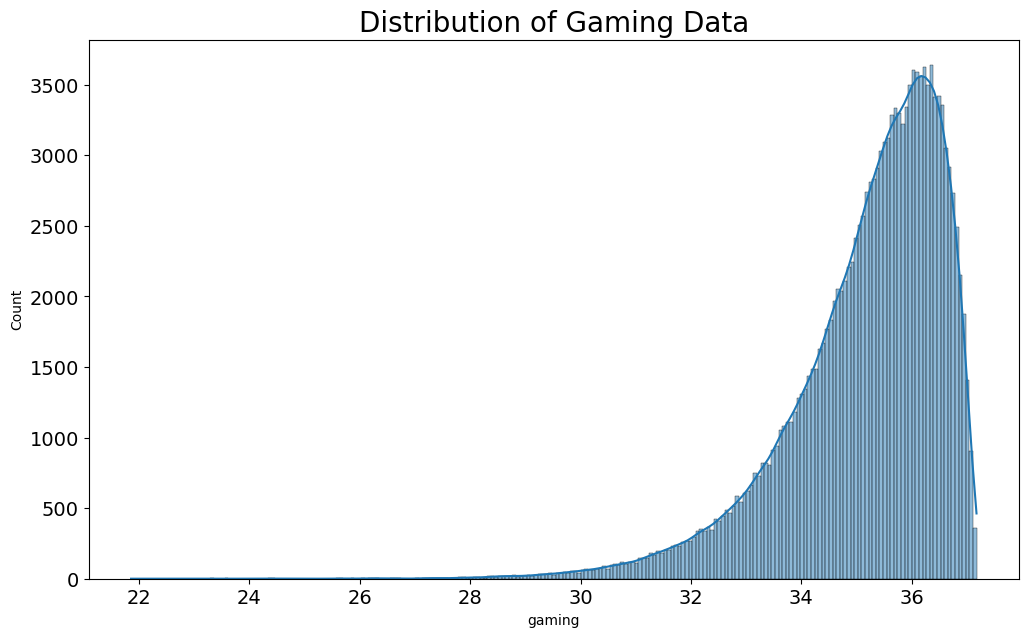

In [87]:
plots.plot_hist(df=df, column='gaming', title='Distribution of Gaming Data')

Most of the social media data is negatively skewed

**Bivariant Analysis**

**Multivariate Graphical EDA**

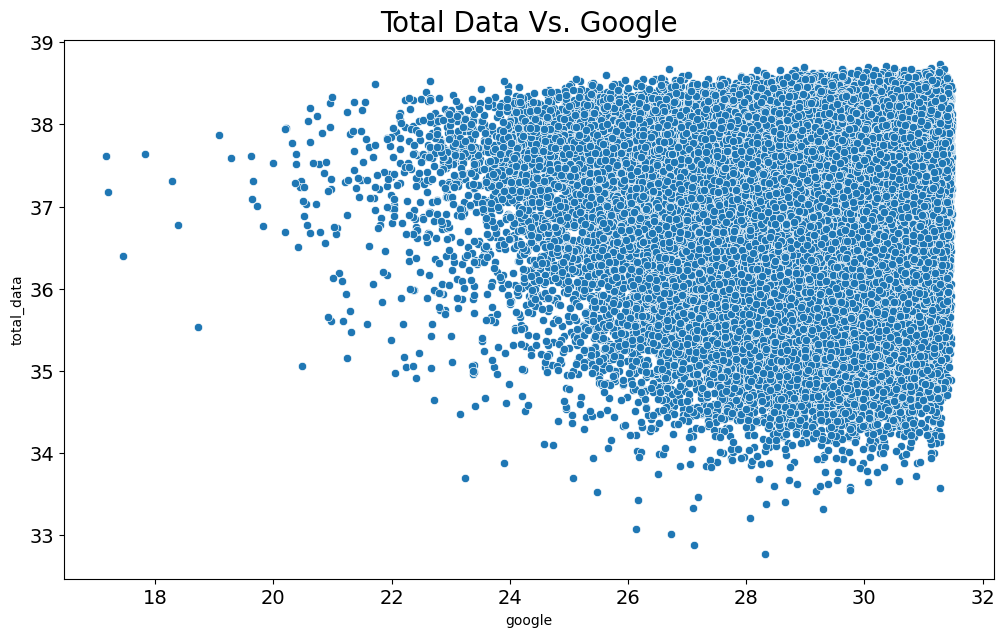

In [24]:
#  Scatter plot between total_data and google application
plots.plot_scatter(df, df['google'], df['total_data'], 'Total Data Vs. Google', None, None)

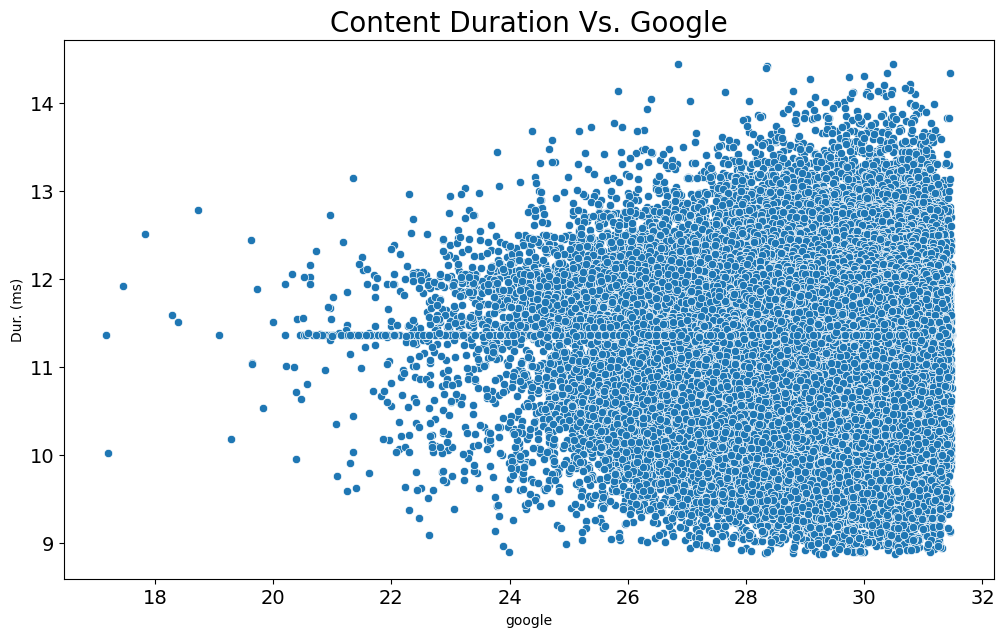

In [25]:
#  Scatter plot between total_data and google application
plots.plot_scatter(df,  df['google'], df['Dur. (ms)'], 'Content Duration Vs. Google', None, None)

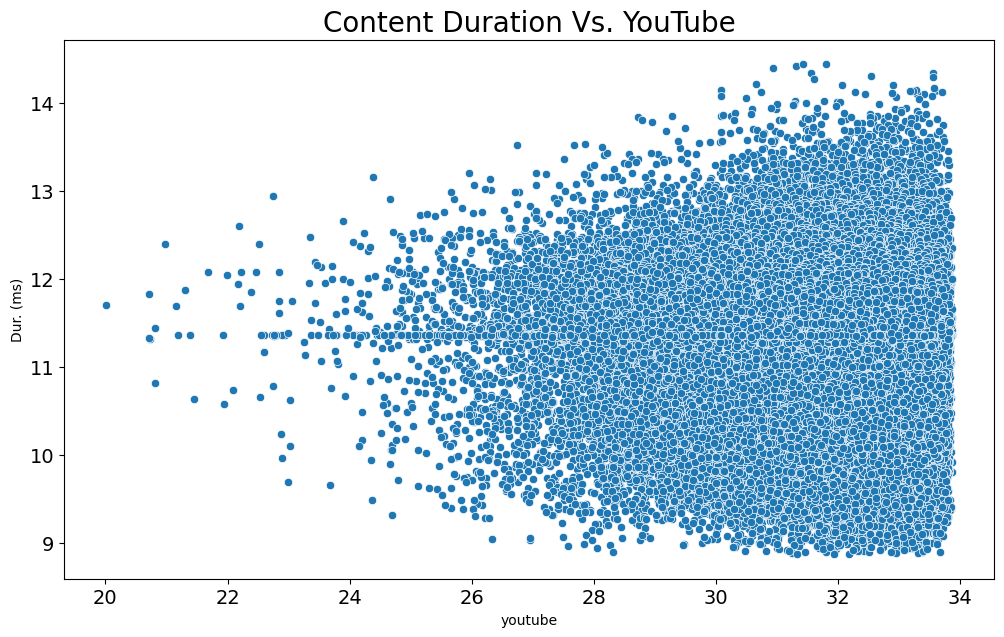

In [85]:
#  Scatter plot between total_data and youtube application
plots.plot_scatter(df,  df['youtube'], df['Dur. (ms)'], 'Content Duration Vs. YouTube', None, None)

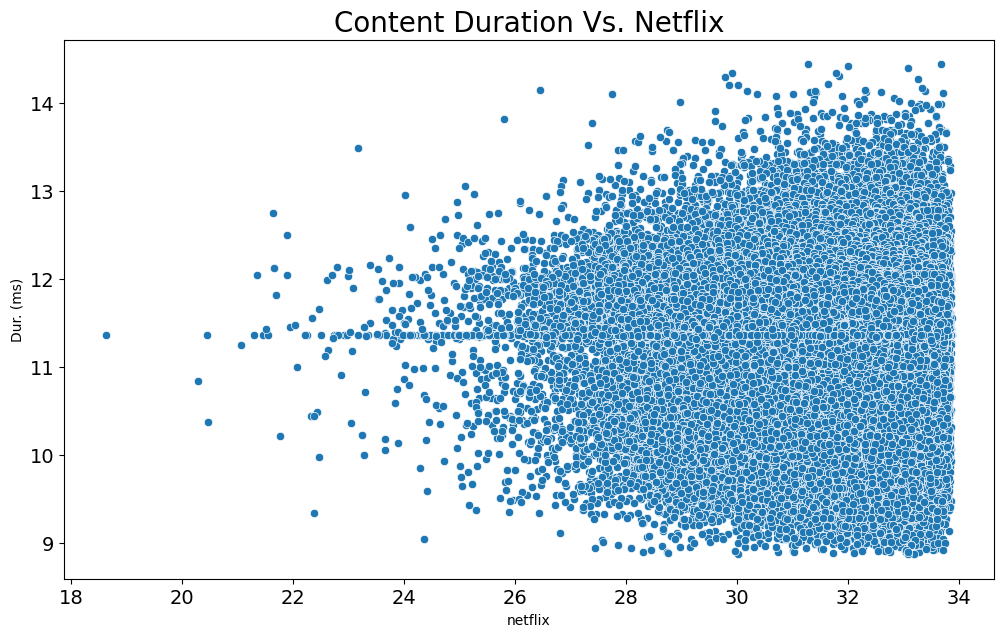

In [86]:
#  Scatter plot between XDR Duration and youtube application
plots.plot_scatter(df,  df['netflix'], df['Dur. (ms)'], 'Content Duration Vs. Netflix', None, None)

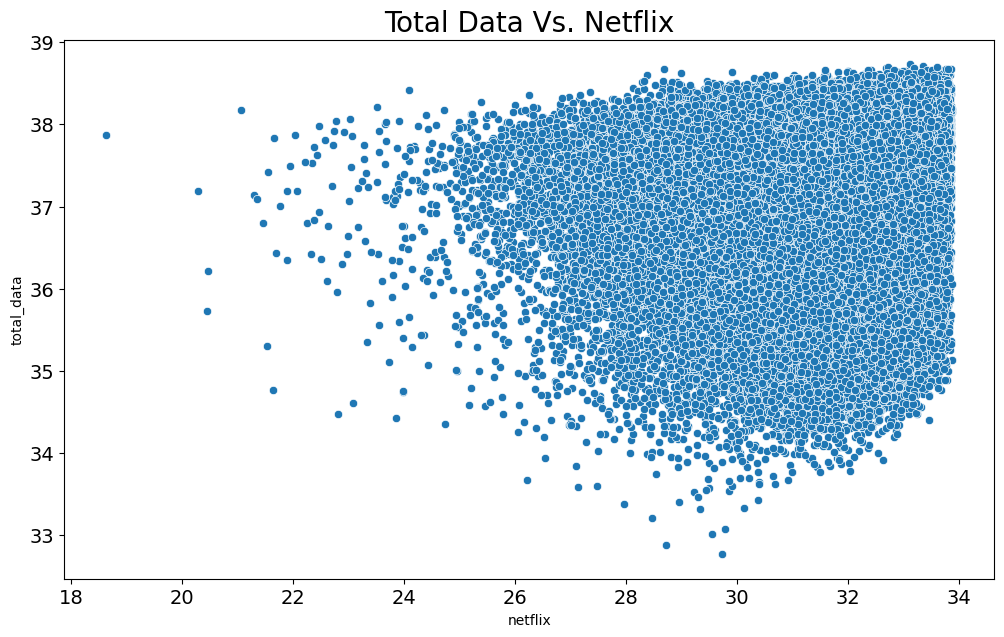

In [28]:
#  Scatter plot between total_data and netflix application
plots.plot_scatter(df, df['netflix'], df['total_data'], 'Total Data Vs. Netflix', None, None)

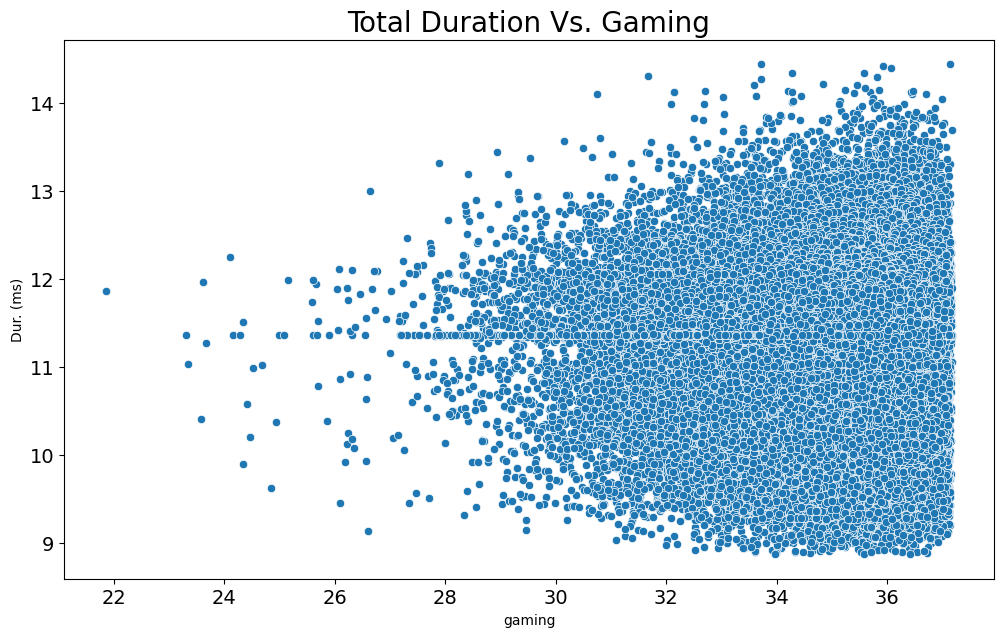

In [89]:
#  Scatter plot between total_data and gaming application
plots.plot_scatter(df, df['gaming'], df['Dur. (ms)'], 'Total Duration Vs. Gaming', None, None)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


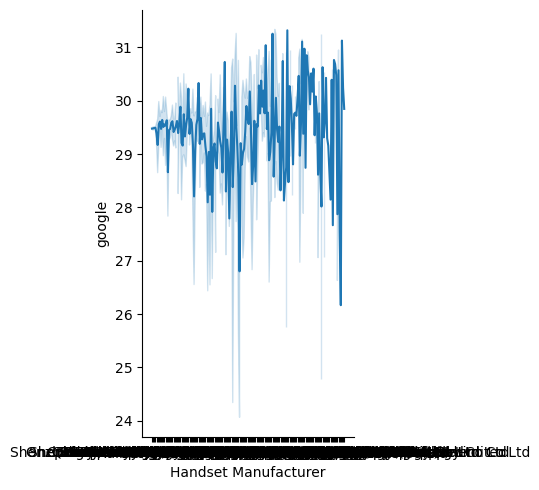

In [30]:
sns.relplot(data=df, x="Handset Manufacturer", y="google", hue=None, kind="line")

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


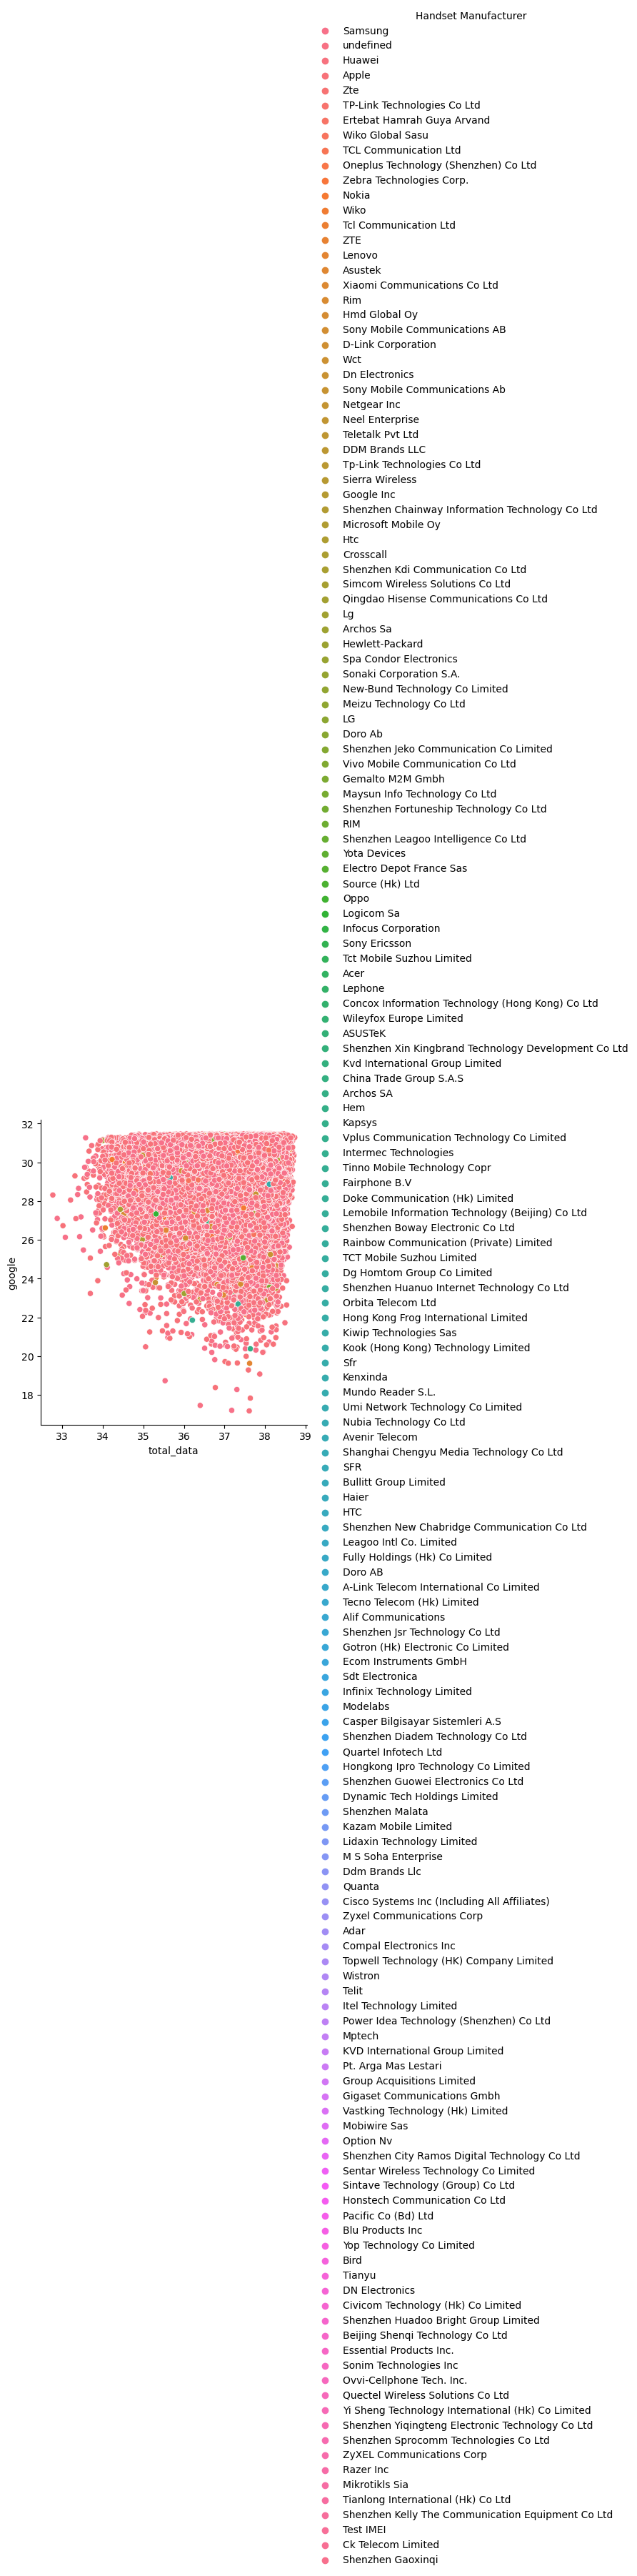

In [31]:
sns.relplot(x="total_data", y="google", hue="Handset Manufacturer", data=df);

In [32]:
preprocess = PreProcess(df)

In [33]:
df2 = df.copy()

In [34]:
# df = pd.read_excel('../data/Week1_challenge_data_source.xlsx')
df3 = pd.read_csv('../data/cleaned_data2.csv')

In [35]:
feature_to_use = df3[['msisdn/number', 'social_media', 'google', 'email', 'youtube', 'netflix',
                                 'gaming',  'other', 'total_data', 'handset_manufacturer']]

In [36]:
feature_to_use.head()

,msisdn/number,social_media,google,email,youtube,netflix,gaming,other,total_data,handset_manufacturer
0,3.366496e+10,1.570185,2.905912,3.701304,18.355943,17.855187,292.426453,180.558843,345.629377,Samsung
1,3.368185e+10,1.933278,4.414096,0.937385,39.359124,35.565545,609.920783,541.959383,707.185356,Samsung
2,3.376063e+10,1.726277,10.229119,3.363124,34.425237,23.751202,229.980251,414.908351,307.690973,Samsung
3,3.375034e+10,0.657493,11.811761,2.070983,36.534765,15.092588,810.387875,761.837216,889.352748,undefined
4,3.369980e+10,0.912788,7.748843,2.110349,34.222253,17.539799,531.237049,564.619822,607.681403,Samsung


In [37]:
total_count_app = pd.DataFrame()

In [38]:
# social_media_total = feature_to_use.sum()[0]
google_total = feature_to_use.sum()[1]
email_total = feature_to_use.sum()[2]
youtube_total = feature_to_use.sum()[3]
netflix_total = feature_to_use.sum()[4]
gaming_total = feature_to_use.sum()[5]
other_total = feature_to_use.sum()[6]

In [39]:
total_count_app['app'] = ['google', 'email', 'youtube', 'netflix', 'gaming', 'other']
total_count_app['total'] = [google_total, email_total, youtube_total, netflix_total, gaming_total,  other_total]

In [40]:
total_count_app.head(6)

,app,total
0,google,2.742394e+05
1,email,1.171102e+06
2,youtube,3.388676e+05
3,netflix,3.396545e+06
4,gaming,3.394314e+06
5,other,6.455040e+07


In [41]:
total_count_app.head()

,app,total
0,google,2.742394e+05
1,email,1.171102e+06
2,youtube,3.388676e+05
3,netflix,3.396545e+06
4,gaming,3.394314e+06


In [42]:
total_count_app

,app,total
0,google,2.742394e+05
1,email,1.171102e+06
2,youtube,3.388676e+05
3,netflix,3.396545e+06
4,gaming,3.394314e+06
5,other,6.455040e+07


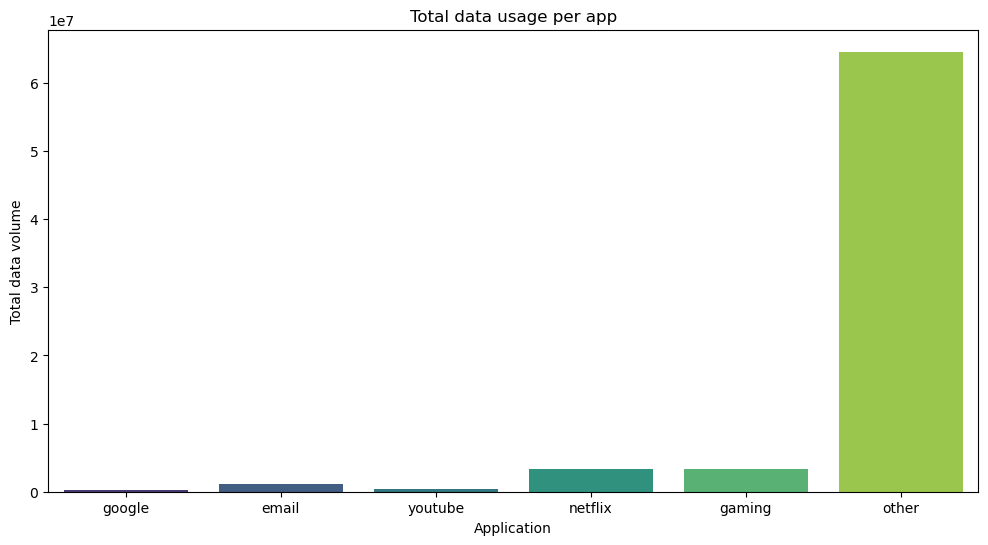

In [43]:
plots.plot_bar(x=total_count_app['app'], y=total_count_app['total'], title="Total data usage per app", xlabel="Application", ylabel="Total data volume")


**Variable Transformations**

In [44]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [45]:
var_tr = df[['MSISDN/Number', 'Dur. (ms)', 'total_data']]

In [46]:
var_tr_agg = var_tr.groupby('MSISDN/Number').agg({'Dur. (ms)':'sum', 'total_data': 'sum'})

In [47]:
var_tr_agg.shape

(106856, 2)

In [48]:
var_tr_agg_decile = overview.get_decile(var_tr_agg, 'Dur. (ms)', 5, ['First Decile', 'Second Decile', 'Third Decile', 'Fourth Decile', 'Fifth Decile'])

In [49]:
var_tr_agg_decile.head()

,Dur. (ms),total_data,deciles
MSISDN/Number,,,
3.360100e+10,11.667533,37.952551,Third Decile
3.360100e+10,12.107522,36.011203,Fourth Decile
3.360100e+10,11.812800,37.624373,Third Decile
3.360101e+10,10.817335,36.639432,First Decile
3.360101e+10,19.656666,75.943057,Fourth Decile


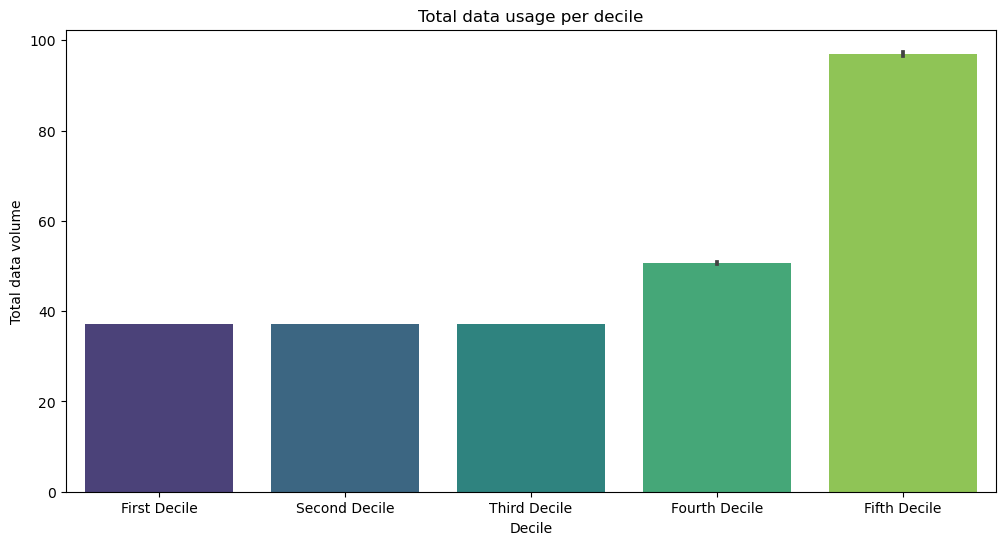

In [50]:
plots.plot_bar(x=var_tr_agg_decile['deciles'], y=var_tr_agg_decile['total_data'] , title="Total data usage per decile", xlabel="Decile", ylabel="Total data volume")

**Correlation Analysis**

In [51]:
corr_analysis = df3[['msisdn/number','social_media', 'google',
                    'email', 'youtube', 'netflix', 'gaming', 'other']]

In [52]:
# Aggregate social app data by msisdn/number
corr_analysis_agg = corr_analysis.groupby('msisdn/number').agg({'social_media':'sum', 'google':'sum', 'email':'sum', 'youtube':'sum', 'netflix':'sum', 'gaming':'sum', 'other':'sum'})

In [53]:
# corr_analysis_agg.corr()
plots.plot_heatmap(corr_analysis_agg, "Correlation between apps")
# This takes too long to work on local machine

In [54]:
corr_analysis_agg.corr()

,social_media,google,email,youtube,netflix,gaming,other
social_media,1.000000,0.969010,0.967948,0.971362,0.971349,0.962478,0.961870
google,0.969010,1.000000,0.974119,0.977718,0.977487,0.968700,0.968014
email,0.967948,0.974119,1.000000,0.976342,0.976363,0.967152,0.966720
youtube,0.971362,0.977718,0.976342,1.000000,0.980146,0.970956,0.970447
netflix,0.971349,0.977487,0.976363,0.980146,1.000000,0.970908,0.970013
gaming,0.962478,0.968700,0.967152,0.970956,0.970908,1.000000,0.961151
other,0.961870,0.968014,0.966720,0.970447,0.970013,0.961151,1.000000


*Dimenstionlity Reduction using PCA*

In [57]:
# Non-Graphical Univariate analysis for the categorical variables
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = list(set(df.columns) - set(num_cols))

In [58]:
df[num_cols].columns

Index(['Bearer Id', 'Start ms', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number',
       'IMEI', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
       'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)',
       'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)',
       '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)',
       'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)',
       '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)',
       'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)',
       'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1',
       'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',
       'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B',
       'Soci

In [59]:
num_final = [col for col in num_cols if col not in ['msisdn/number','bearer_id', 'start_ms', 'end_ms', 'imsi', 'imei']]

In [60]:
len(num_final)

58

In [61]:
len(df.columns)

63

**Standardize features**

In [69]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [70]:
df2 = df.copy()

In [71]:
df2 = clean_dataset(df2[num_final])

/var/folders/04/3b1dms951y10x8q5rqfj4twr0000gn/T/ipykernel_30786/3521111987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [72]:
df2.shape

(954, 58)

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df2)
df_scaled = scaler.transform(df2)

In [74]:
df_scaled.shape

(954, 58)

In [75]:
from sklearn.decomposition import PCA
pca_44 = PCA(n_components=44, random_state=42)
pca_44.fit(df_scaled)

PCA(n_components=44, random_state=42)

In [76]:
x_pca_44 = pca_44.transform(df_scaled)

In [77]:
x_pca_44.shape 

(954, 44)

In [78]:
sum(pca_44.explained_variance_ratio_)

0.9998295362608383

In [79]:
np.cumsum(pca_44.explained_variance_ratio_ * 100)

array([23.11142494, 29.50331428, 34.26738894, 38.68461143, 42.87125178,
       46.67771278, 50.32353909, 53.91683249, 57.42107854, 60.5324054 ,
       63.52131536, 66.08253464, 68.63704343, 70.91594688, 73.13254197,
       75.1780229 , 77.09522537, 79.00115338, 80.79129612, 82.56887124,
       84.25678248, 85.92084362, 87.54291934, 89.05925307, 90.51133145,
       91.90563401, 93.07417075, 94.12429714, 95.08727928, 95.92117446,
       96.66074669, 97.24450008, 97.78613848, 98.31127516, 98.71408142,
       99.0936813 , 99.42291955, 99.68088917, 99.81258891, 99.87337365,
       99.93152727, 99.96132468, 99.97563391, 99.98295363])

Text(0, 0.5, 'Cumulative Explained Variance')

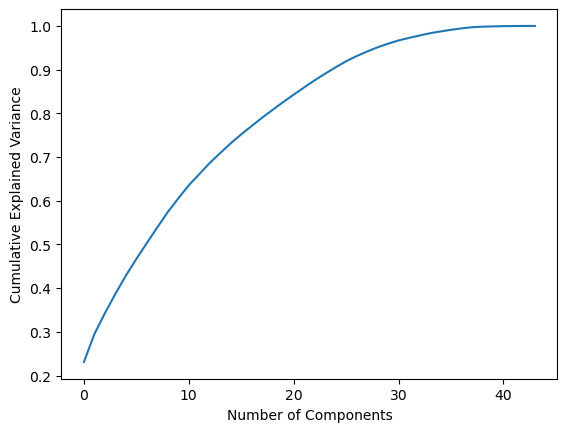

In [80]:
plt.plot(np.cumsum(pca_44.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [81]:
print("Variance explained by first Principal components: {}".format( np.cumsum(pca_44.explained_variance_ratio_ * 100)[0]))
print("Variance explained by  2 Principal components: {}".format( np.cumsum(pca_44.explained_variance_ratio_ * 100)[1]))
print("Variance explained by  3 Principal components: {}".format( np.cumsum(pca_44.explained_variance_ratio_ * 100)[2]))
print("Variance explained by  10 Principal components: {}".format( np.cumsum(pca_44.explained_variance_ratio_ * 100)[9]))

Variance explained by first Principal components: 23.1114249428604
Variance explained by  2 Principal components: 29.503314281672097
Variance explained by  3 Principal components: 34.2673889380495
Variance explained by  10 Principal components: 60.532405400556236


In [82]:
#  Apply PCA by setting n_components=0.65
pca_65 = PCA(n_components=0.65, random_state=42)
pca_65.fit(df_scaled)
df_pca_95 = pca_65.transform(df_scaled)

In [83]:
df_pca_95.shape

(954, 12)

The feature has now been reduced to 12 dimensions